<a href="https://colab.research.google.com/github/husuninder/diffusion-models-tutorial/blob/master/toy-density-estimation/colab_vanilla_diffusion_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# density estimation using diffusion models

1. We will experiment to generate simple distributions over 2 dimensions using diffusion models
2. Following we will try to generate class conditioned distribution based on a simple labelling strategy

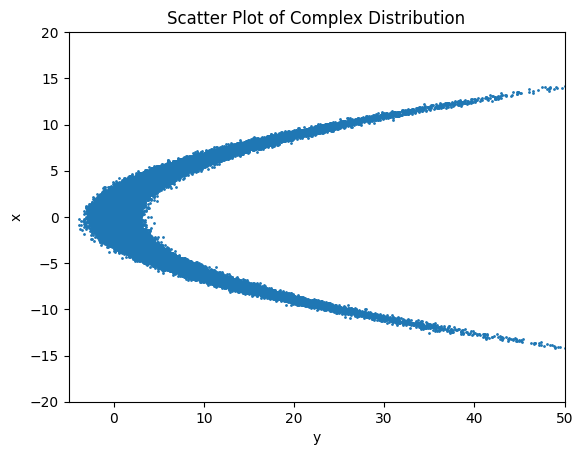

In [2]:
# create a dataset of 10K points, sampled from some complex distribution

import torch
from matplotlib import pyplot as plt

samples = 1024*128
x = torch.normal(mean=0, std=4, size=(1, samples))
y = torch.normal(mean=0.25*torch.ones(samples)*x*x, std=torch.ones(samples)*1)

plt.scatter(y.numpy(), x.numpy(), s=1)  # Convert to numpy for matplotlib compatibility
plt.xlim([-5, 50])
plt.ylim([-20, 20])
plt.xlabel('y')
plt.ylabel('x')
plt.title('Scatter Plot of Complex Distribution')
plt.show()


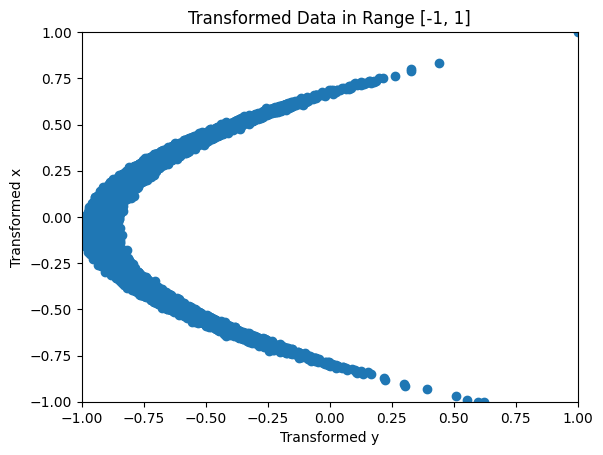

In [4]:
# Stack `y` and `x` vertically to create a 2xN tensor.
data = torch.vstack([y, x])

# Define a function to transform data into the range [-1, 1].
def transform(data):
    # Find the minimum and maximum values for each row (feature).
    min_, max_ = torch.min(data, axis=1), torch.max(data, axis=1)

    # Transform data to the range [0, 1]:
    # Subtract the minimum value from each element, then divide by the range (max - min).
    # Extend to [-1, 1] by multiplying by 2 and subtracting 1.
    data_transformed = 2 * (data.sub(min_.values[:, None])).div((max_.values - min_.values)[:, None]) - 1

    # Return the transformed data, along with the original min and max values for reference.
    return data_transformed, min_, max_

# Apply the transformation to the data.
data_transformed, min_, max_ = transform(data)

# Plot the transformed data.
plt.scatter(data_transformed[0], data_transformed[1])  # Scatter plot of the transformed data.
plt.xlim([-1, 1])  # Set x-axis limits to [-1, 1].
plt.ylim([-1, 1])  # Set y-axis limits to [-1, 1].
plt.xlabel('Transformed y')  # Label for the x-axis.
plt.ylabel('Transformed x')  # Label for the y-axis.
plt.title('Transformed Data in Range [-1, 1]')  # Plot title.
plt.show()


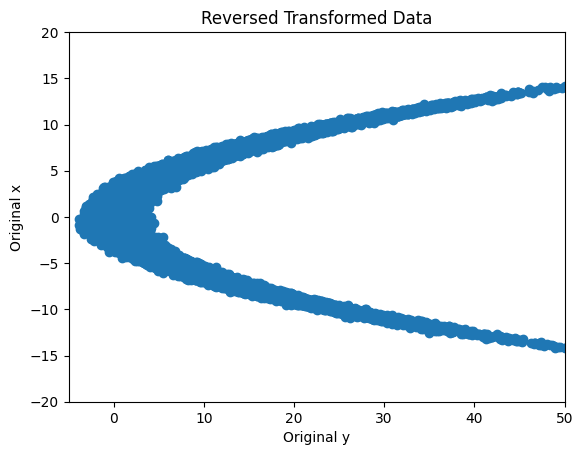

In [5]:
# Define a function to reverse the transformation, mapping data back to its original range.
def reverse_transform(data_transformed, min_, max_):
    # The original transformation:
    # data_transformed = 2 * (data - min_) / (max_ - min_) - 1
    # Reverse the transformation step-by-step:
    # 1. Add 1 to data_transformed to bring it back to [0, 2].
    # 2. Multiply by (max_ - min_) to restore the original range's scale.
    # 3. Add min_ * 2 and divide by 2 to adjust for the final offset and scaling.
    data = (data_transformed + 1).mul((max_.values - min_.values)[:, None]).add(min_.values[:, None] * 2) / 2

    # Return the data in its original scale.
    return data

# Reverse the transformation on the scaled data.
data = reverse_transform(data_transformed, min_, max_)

# Plot the data in its original scale.
plt.scatter(data[0], data[1])  # Scatter plot of the reversed data.
plt.xlim([-5, 50])  # Set x-axis limits to match the original data's range.
plt.ylim([-20, 20])  # Set y-axis limits to match the original data's range.
plt.xlabel('Original y')  # Label for the x-axis.
plt.ylabel('Original x')  # Label for the y-axis.
plt.title('Reversed Transformed Data')  # Plot title.
plt.show()


In the context of diffusion models, the various beta schedules — **quadratic**, **linear**, **cosine**, and **sigmoid** — define how noise is incrementally added to the data during the forward diffusion process. These schedules govern the rate at which the signal degrades over time, which directly impacts the quality of the model's training and subsequent sampling in the reverse diffusion process.

---

### **Diffusion Models: A Conceptual Overview**
Diffusion models are generative models that learn to denoise data through a reverse process. The training involves two main processes:
1. **Forward Diffusion Process**:
   - Gradually corrupts data by adding noise over several timesteps.
   - At timestep \( $t$ \), the data becomes noisier based on the variance schedule defined by the beta values ( $\beta_t$ ).
   - The beta values control how much noise is added at each step.

2. **Reverse Diffusion Process**:
   - Learns to reverse the forward process by denoising the data step-by-step, starting from pure noise.
   - The learned denoising process allows the generation of new samples from noise.

---

### **Role of Beta Schedules**
The **beta schedule** determines how noise is added during the forward process. Different schedules impact:
- **Smoothness** of noise addition.
- The ability of the reverse process to learn denoising.
- The overall training stability and sample quality.

---

### **Beta Schedules Explained**

#### **1. Linear Beta Schedule**
- **Definition**: Beta values increase linearly over the timesteps.
  -  $\beta_t = \text{linspace}(\text{start}, \text{end}, \text{timesteps}$ \)
- **Effect**:
  - Noise is added at a constant rate.
  - Simple and widely used because it offers a uniform degradation of the signal.
- **Advantages**:
  - Easy to implement and provides a good baseline for diffusion models.
- **Drawbacks**:
  - May not handle fine-grained noise addition well for certain data distributions.

#### **2. Quadratic Beta Schedule**
- **Definition**: Beta values increase quadratically over the timesteps.
  - \( $\beta_t \propto t^2 $\)
- **Effect**:
  - Noise increases slowly at the beginning and accelerates toward the end.
  - Adds minimal noise in the early timesteps, preserving more details in the data.
- **Advantages**:
  - Suitable for cases where fine details at the start of diffusion are critical.
- **Drawbacks**:
  - Higher noise accumulation at later timesteps can lead to instability in learning.

#### **3. Cosine Beta Schedule**
- **Definition**: Uses a cosine function to compute cumulative alphas ($ \alpha_t $), from which betas are derived.
  -  $ \alpha_t = \cos^2\left(\frac{\pi}{2} \cdot \frac{t + s}{1 + s}\right)$
  -  $\beta_t = 1 - \frac{\alpha_{t+1}}{\alpha_t}$
- **Effect**:
  - Smoothly decreases the signal over time, with a focus on preserving more signal in the early timesteps.
- **Advantages**:
  - Leads to better signal preservation and higher-quality samples, as demonstrated in state-of-the-art diffusion models.
  - Works well for image and audio generation tasks.
- **Drawbacks**:
  - More complex to implement compared to linear schedules.

#### **4. Sigmoid Beta Schedule**
- **Definition**: Beta values follow a sigmoid curve.
  -  $ \beta_t = \text{sigmoid}(t) \cdot (\text{end} - \text{start}) + \text{start}$
- **Effect**:
  - Starts slowly, accelerates in the middle, and slows down toward the end.
  - Balances between slow and fast noise addition.
- **Advantages**:
  - Provides flexibility for noise scheduling, making it adaptable to diverse data distributions.
- **Drawbacks**:
  - Requires careful tuning of the sigmoid parameters to fit the specific dataset.

---

### **How They Impact Diffusion Models**
1. **Training Stability**: Smoother schedules like cosine or sigmoid improve training stability by balancing noise addition.
2. **Sample Quality**: Schedules that preserve more signal in earlier steps (e.g., cosine) often result in higher-quality samples.
3. **Adaptability**: Different schedules suit different data distributions and tasks. For instance:
   - **Linear** is simple and general-purpose.
   - **Cosine** is excellent for natural images.
   - **Quadratic** may work well for preserving fine details.
   - **Sigmoid** provides a middle ground with flexibility.

---

### **Summary**
- The **beta schedule** is a critical component of diffusion models, dictating how noise is added during the forward process.
- Each schedule has unique characteristics and trade-offs that influence model performance and training.
- Choosing the right schedule depends on the task, data distribution, and desired trade-off between complexity and performance.

In [6]:
# Define a cosine beta schedule as proposed in the diffusion model paper (https://arxiv.org/abs/2102.09672).
def cosine_beta_schedule(timesteps, s=0.008):
    """
    Creates a beta schedule using a cosine function, which provides smooth transitions in variance.
    Args:
        timesteps: The number of timesteps in the diffusion process.
        s: A small value to ensure numerical stability.
    Returns:
        A tensor containing beta values for each timestep, clipped to [0.0001, 0.9999].
    """
    steps = timesteps + 1  # Include an extra step for cumulative calculations.
    x = torch.linspace(0, timesteps, steps)  # Create equally spaced points between 0 and timesteps.

    # Calculate cumulative alpha values using a cosine function.
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2

    # Normalize to start from 1 (ensures stability).
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]

    # Compute beta values as the complement of the ratio of consecutive alphas.
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])

    # Clip beta values to ensure they remain within a valid range for numerical stability.
    return torch.clip(betas, 0.0001, 0.9999)

# Define a linear beta schedule for the diffusion process.
def linear_beta_schedule(timesteps):
    """
    Linearly increases beta values over the timesteps.
    Args:
        timesteps: The number of timesteps in the diffusion process.
    Returns:
        A tensor of beta values linearly spaced between beta_start and beta_end.
    """
    beta_start = 0.0001  # Starting beta value (low noise).
    beta_end = 0.25      # Ending beta value (higher noise).
    return torch.linspace(beta_start, beta_end, timesteps)

# Define a quadratic beta schedule for the diffusion process.
def quadratic_beta_schedule(timesteps):
    """
    Quadratically increases beta values over the timesteps.
    Args:
        timesteps: The number of timesteps in the diffusion process.
    Returns:
        A tensor of beta values that grow quadratically from beta_start to beta_end.
    """
    beta_start = 0.0001  # Starting beta value (low noise).
    beta_end = 0.02      # Ending beta value (higher noise).

    # Compute square root of the range and square it for quadratic growth.
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

# Define a sigmoid beta schedule for the diffusion process.
def sigmoid_beta_schedule(timesteps):
    """
    Sigmoidally increases beta values over the timesteps.
    Args:
        timesteps: The number of timesteps in the diffusion process.
    Returns:
        A tensor of beta values that grow following a sigmoid curve.
    """
    beta_start = 0.0001  # Starting beta value (low noise).
    beta_end = 0.02      # Ending beta value (higher noise).

    # Generate evenly spaced points between -6 and 6 (sigmoid range).
    betas = torch.linspace(-6, 6, timesteps)

    # Apply sigmoid transformation and scale to the desired beta range.
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start




### **Mathematical Explanation of the Forward Process in Diffusion Models**

The forward diffusion process in diffusion models gradually corrupts the data $ \mathbf{x}_0 $ by adding Gaussian noise over $ T $ timesteps. At each timestep $ t $, the data becomes progressively noisier, until it approaches a nearly pure Gaussian distribution at $ t = T $.

---

### **Key Elements of the Forward Process**
1. **Data Initialization**:
   - The initial data is denoted as $ \mathbf{x}_0 $ (e.g., an image or other structured data).

2. **Adding Noise**:
   - At each timestep $ t $, Gaussian noise is added to the data.
   - The amount of noise is controlled by a schedule $ \beta_t $, which defines the variance of the noise added at each timestep.

3. **Noisy Data at Timestep $ t $**:
   - The noisy data $ \mathbf{x}_t $ is a mixture of the original data $ \mathbf{x}_0 $ and Gaussian noise, scaled by factors derived from $ \beta_t $.

---

### **Mathematical Formulation**

#### **1. Transition from $ \mathbf{x}_t $ to $ \mathbf{x}_{t+1} $**
At each timestep, noise is added:
$$
\mathbf{x}_{t+1} = \sqrt{1 - \beta_t} \cdot \mathbf{x}_t + \sqrt{\beta_t} \cdot \mathbf{\epsilon}
$$
where:
- $ \beta_t $: Variance schedule at timestep $ t $.
- $ \mathbf{\epsilon} \sim \mathcal{N}(\mathbf{0}, \mathbf{I}) $: Gaussian noise.

#### **2. Direct Sampling of $ \mathbf{x}_t $ from $ \mathbf{x}_0 $**
Instead of iteratively applying the above equation, we can directly sample $ \mathbf{x}_t $ from $ \mathbf{x}_0 $ using the cumulative noise schedule:
$$
\mathbf{x}_t = \sqrt{\alpha_t} \cdot \mathbf{x}_0 + \sqrt{1 - \alpha_t} \cdot \mathbf{\epsilon}
$$
where:
- $ \alpha_t = \prod_{i=1}^t (1 - \beta_i) $: The cumulative product of the signal preservation factor.
- $ 1 - \alpha_t $: The cumulative noise variance.

This equation captures the signal ($ \mathbf{x}_0 $) and noise ($ \mathbf{\epsilon} $) components directly, based on $ t $.

#### **3. Variance and Standard Deviation**
The noise at timestep $ t $ is Gaussian, with:
$$
\text{Variance} = 1 - \alpha_t
$$
$$
\text{Standard Deviation} = \sqrt{1 - \alpha_t}
$$

---

### **Key Insights**
1. **Progressive Corruption**:
   - At $ t = 0 $: $ \mathbf{x}_t = \mathbf{x}_0 $ (no noise).
   - At $ t = T $: $ \mathbf{x}_T \sim \mathcal{N}(\mathbf{0}, \mathbf{I}) $ (almost pure noise).

2. **Signal-to-Noise Ratio**:
   - The cumulative product $ \alpha_t $ decreases over time, reducing the signal's strength.
   - $ 1 - \alpha_t $ increases over time, amplifying the noise.

---

### **Relevance of Beta Schedules**
The schedule $ \beta_t $ defines how fast $ \alpha_t $ decreases and noise accumulates:
- **Linear Schedule**: Noise accumulates at a constant rate.
- **Cosine Schedule**: Preserves more signal initially for better training.
- **Quadratic/Sigmoid Schedule**: Provides slower or more controlled noise accumulation.

---

### **Visualization**
For intuition, imagine a 1D example:
- $ \mathbf{x}_0 $ is a point on the line.
- Over timesteps, $ \mathbf{x}_t $ becomes a Gaussian cloud around $ \mathbf{x}_0 $, gradually spreading out until it fully resembles a standard Gaussian distribution.

This forward process ensures the data transitions from structured input to pure noise, enabling the reverse process to learn how to reconstruct the original data.



### **1. Forward Diffusion Process**

The forward process adds Gaussian noise to the data at each timestep $t$, following this equation:
$$
\mathbf{x}_t = \sqrt{\alpha_t} \cdot \mathbf{x}_0 + \sqrt{1 - \alpha_t} \cdot \mathbf{\epsilon},
$$
where:
- $\mathbf{x}_t$ is the noisy version of the original data $\mathbf{x}_0$ at timestep $t$.
- $\alpha_t$ is the cumulative product of signal preservation factors:
  $$
  \alpha_t = \prod_{i=1}^t (1 - \beta_i).
  $$
- $\mathbf{\epsilon} \sim \mathcal{N}(0, \mathbf{I})$ is standard Gaussian noise.

This equation explicitly shows that $\mathbf{x}_t$ is a **weighted sum** of:
1. $\sqrt{\alpha_t}$: The preserved signal from $\mathbf{x}_0$.
2. $\sqrt{1 - \alpha_t}$: The added Gaussian noise.

---

### **2. Decomposing $\mathbf{x}_t$**

We can rewrite $\mathbf{x}_t$ as:
$$
\mathbf{x}_t = \sqrt{\alpha_t} \cdot \mathbf{x}_0 + \sqrt{1 - \alpha_t} \cdot \mathbf{\epsilon}.
$$

#### **Variance of $\mathbf{x}_t$**
Variance is a measure of how much a random variable deviates from its mean. Assuming $\mathbf{x}_0$ and $\mathbf{\epsilon}$ are independent, the variance of $\mathbf{x}_t$ is given by the sum of the variances of the two components:
$$
\text{Var}(\mathbf{x}_t) = \text{Var}\left(\sqrt{\alpha_t} \cdot \mathbf{x}_0\right) + \text{Var}\left(\sqrt{1 - \alpha_t} \cdot \mathbf{\epsilon}\right).
$$

1. **Signal Contribution** ($\mathbf{x}_0$):
   - If $\mathbf{x}_0$ has variance $\sigma_x^2$ (e.g., normalized to 1), then:

     $$
     \text{Var}\left(\sqrt{\alpha_t} \cdot \mathbf{x}_0\right) = \alpha_t \cdot \sigma_x^2.
     $$

2. **Noise Contribution** ($\mathbf{\epsilon}$):
   - $\mathbf{\epsilon} \sim \mathcal{N}(0, \mathbf{I})$, so it has variance 1.
     
     $$
     \text{Var}\left(\sqrt{1 - \alpha_t} \cdot \mathbf{\epsilon}\right) = (1 - \alpha_t) \cdot 1.
     $$

#### **Total Variance**
The total variance of $\mathbf{x}_t$ is:
$$
\text{Var}(\mathbf{x}_t) = \alpha_t + (1 - \alpha_t) = 1.
$$

This shows that $1 - \alpha_t$ represents the **proportion of the variance contributed by the noise**.

---

### **3. Intuition: Why is $1 - \alpha_t$ the Variance of the Noise?**

From the equation:
$$
\mathbf{x}_t = \sqrt{\alpha_t} \cdot \mathbf{x}_0 + \sqrt{1 - \alpha_t} \cdot \mathbf{\epsilon},
$$
- The **signal strength** is determined by $\sqrt{\alpha_t}$.
- The **noise strength** is determined by $\sqrt{1 - \alpha_t}$.

Since the noise $\mathbf{\epsilon}$ has unit variance ($\text{Var}(\mathbf{\epsilon}) = 1$):
- The variance contributed by the noise term is scaled by $(1 - \alpha_t)$.
- Hence, $1 - \alpha_t$ is the variance of the noise component added at timestep $t$.

---

### **4. Practical Perspective in Diffusion Models**

In the forward process:
- $\alpha_t$: Represents the proportion of the original signal $\mathbf{x}_0$ that remains uncorrupted at timestep $t$.
- $1 - \alpha_t$: Represents the proportion of the data that has been corrupted by noise (variance of the noise).

This balance ensures that over time:
1. $\alpha_t \to 0$: The signal diminishes.
2. $1 - \alpha_t \to 1$: The noise dominates.

This gradual corruption is essential for the reverse diffusion process, where the model learns to recover $\mathbf{x}_0$ from $\mathbf{x}_t$.

---

### **Key Takeaway**
- $1 - \alpha_t$ is mathematically the **variance of the noise** because it directly scales the Gaussian noise $\mathbf{\epsilon}$ added to $\mathbf{x}_0$ during the forward process. It quantifies how much of the original signal has been replaced by noise at each timestep.

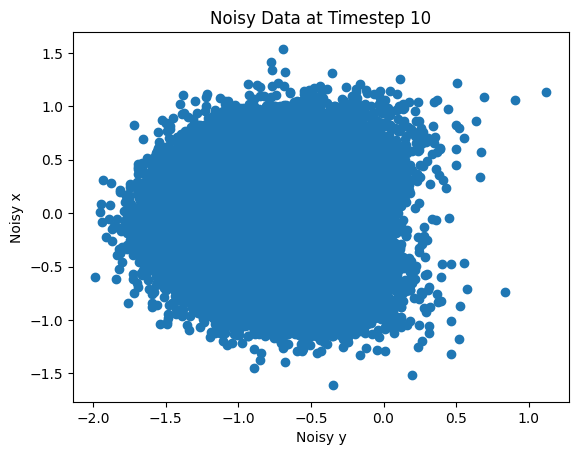

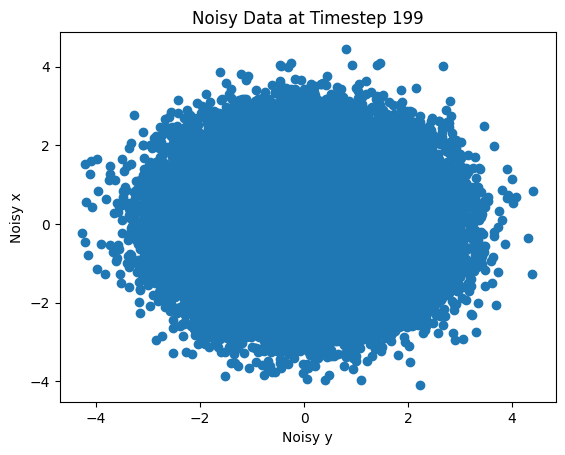

In [21]:
# Define the number of timesteps for the diffusion process.
timesteps = 200

# Select the beta schedule. Using a linear beta schedule here.
betas = linear_beta_schedule(timesteps)  # Tensor of beta values for each timestep.

# Compute alpha values, which represent the remaining signal after adding noise.
alphas = 1 - betas  # Alpha is the complement of beta.

# Compute the cumulative product of alphas, which represents the total signal preserved up to each timestep.
alphas_ = torch.cumprod(alphas, axis=0)

# Variance at each timestep is the complement of the cumulative alpha product.
variance = 1 - alphas_

# Standard deviation at each timestep, used for generating noise.
sd = torch.sqrt(variance)

import torch.nn.functional as F

# Compute the cumulative product of alphas for the previous timestep.
# This is padded with 1.0 at the beginning to account for the first timestep.
alphas_prev_ = F.pad(alphas_[:-1], [1, 0], "constant", 1.0)

# Function to add noise to the data at a specific timestep.
def get_noisy(batch, timestep):
    """
    Add noise to the batch of data at a given timestep.
    Args:
        batch: The input data to which noise will be added.
        timestep: The specific timestep to calculate the noise.
    Returns:
        The noisy data at the given timestep.
    """
    # Compute the noisy data at timestep `t`:
    # 1. Scale the batch by the square root of alpha_cumprod at timestep `t`.
    # 2. Add Gaussian noise with standard deviation corresponding to the timestep.
    added_noise_at_t = torch.normal(batch * torch.sqrt(alphas_[timestep]), std=sd[timestep])
    return added_noise_at_t


# Example: Add noise to the data at the 10th timestep.
added_noise_at_t = get_noisy(data_transformed, 10)

# Visualize the noisy data.
plt.scatter(added_noise_at_t[0], added_noise_at_t[1])  # Scatter plot of noisy data.
plt.xlabel('Noisy y')  # Label for the x-axis.
plt.ylabel('Noisy x')  # Label for the y-axis.
plt.title(f'Noisy Data at Timestep {10}')  # Plot title.
plt.show()


# Example: Add noise to the data at the last timestep.
added_noise_at_t = get_noisy(data_transformed, timesteps - 1)

# Visualize the noisy data.
plt.scatter(added_noise_at_t[0], added_noise_at_t[1])  # Scatter plot of noisy data.
plt.xlabel('Noisy y')  # Label for the x-axis.
plt.ylabel('Noisy x')  # Label for the y-axis.
plt.title(f'Noisy Data at Timestep {timesteps - 1}')  # Plot title.
plt.show()

# Compute the posterior variance:
# Represents the variance of the posterior distribution at each timestep in the diffusion process.
posterior_variance = (1 - alphas) * (1 - alphas_prev_) / (1 - alphas)


In [19]:


torch.var_mean(data_transformed, dim=1), torch.var_mean(added_noise_at_t, dim=1)

((tensor([0.0124, 0.0452]), tensor([-0.8479, -0.0614])),
 (tensor([1.0022, 0.9975]), tensor([ 0.0010, -0.0002])))

In [ ]:
torch.sqrt(torch.Tensor([1., 1.])*alphas_[49])

tensor([0.4547, 0.4547])

(tensor([0.0000e+00, 1.0002e-04, 1.4557e-03, 4.0634e-03, 7.9150e-03, 1.2998e-02,
         1.9294e-02, 2.6781e-02, 3.5433e-02, 4.5220e-02, 5.6107e-02, 6.8054e-02,
         8.1021e-02, 9.4961e-02, 1.0983e-01, 1.2557e-01, 1.4212e-01, 1.5945e-01,
         1.7748e-01, 1.9615e-01, 2.1541e-01, 2.3519e-01, 2.5544e-01, 2.7608e-01,
         2.9707e-01, 3.1832e-01, 3.3979e-01, 3.6141e-01, 3.8313e-01, 4.0488e-01,
         4.2661e-01, 4.4827e-01, 4.6980e-01, 4.9116e-01, 5.1230e-01, 5.3317e-01,
         5.5374e-01, 5.7396e-01, 5.9380e-01, 6.1322e-01, 6.3220e-01, 6.5071e-01,
         6.6873e-01, 6.8624e-01, 7.0321e-01, 7.1964e-01, 7.3551e-01, 7.5082e-01,
         7.6555e-01, 7.7970e-01, 7.9328e-01, 8.0628e-01, 8.1871e-01, 8.3056e-01,
         8.4186e-01, 8.5260e-01, 8.6279e-01, 8.7246e-01, 8.8160e-01, 8.9023e-01,
         8.9838e-01, 9.0604e-01, 9.1325e-01, 9.2001e-01, 9.2635e-01, 9.3228e-01,
         9.3781e-01, 9.4297e-01, 9.4778e-01, 9.5224e-01, 9.5638e-01, 9.6022e-01,
         9.6377e-01, 9.6705e

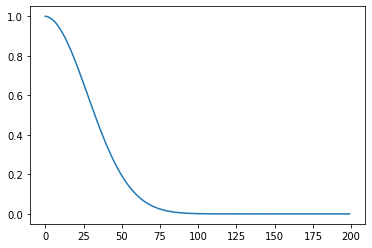

In [ ]:
plt.plot(alphas_)

posterior_variance, alphas, alphas_, (alphas_prev_[1] / (1-alphas_prev_[1])) - (alphas_[1] / (1-alphas_[1]))

# building a model

A 3 layer NN with 8 units each followed by a 2 layer output for x0 data point

The `DenoisingModel` class implements a feedforward neural network (fully connected layers) with multiple layers and GELU activation functions. Here's a detailed breakdown of the model's structure and purpose:

---

### **1. Purpose**
This model is designed for **denoising tasks**, likely in the context of a diffusion model. The goal is to predict the noise or clean signal from corrupted data. This type of model is commonly used in generative modeling tasks, where the network learns to reverse the noise introduced in a forward process.

---

### **2. Network Structure**
The model is a stack of fully connected layers with GELU activation functions and uses Xavier initialization for weights.

#### **Key Components**
- **Input and Output Dimensions**:
  - The input to the model has 3 features (likely representing data dimensions such as $x$, $y$, and a timestep).
  - The final output dimension is 2, suggesting the model predicts two outputs, potentially noise components or a denoised signal in two dimensions.

- **Hidden Layers**:
  - The network has multiple layers, each with `hidden_units` neurons (default = 32).
  - GELU (Gaussian Error Linear Unit) activation is used, which smooths the transitions compared to ReLU and is well-suited for deep learning tasks.

---

### **Layer-by-Layer Analysis**
1. **First Layer Block**:
   - Input: 3 features (e.g., data and timestep).
   - Layers:
     - `fc1`: Maps input from 3 to `hidden_units` (default = 32).
     - GELU activation.
     - `fc2`: Processes the hidden units (32 to 32).
     - GELU activation.
     - `fc3`: Outputs 3 features, likely a projection back to the data space.

2. **Second Layer Block**:
   - Input: 3 features (output of `fc3`).
   - Layers:
     - `fc4`: Maps input to `hidden_units` (32).
     - GELU activation.
     - `fc5`: Processes hidden units (32 to 32).
     - GELU activation.
     - `fc6`: Outputs 3 features.

3. **Third Layer Block**:
   - Input: 3 features (output of `fc6`).
   - Layers:
     - `fc7`: Maps input to `hidden_units` (32).
     - GELU activation.
     - `fc8`: Processes hidden units (32 to 32).
     - GELU activation.
     - `fc9`: Outputs 2 features.

---

### **3. Initialization**
- **Xavier Initialization**:
  - Each layer's weights are initialized using Xavier uniform distribution.
  - This ensures that the weights are scaled appropriately for the activation function (GELU) and input size, improving convergence during training.

---

### **4. Forward Pass**
- The input is processed sequentially through the network:
  - It goes through three blocks of fully connected layers with activations.
  - The output of the last layer (`fc9`) is the final prediction, with two features.

---

### **5. Use Case**
This model could be applied in:
- **Denoising Tasks**: Predict the noise or reconstruct the clean signal from noisy data.
- **Diffusion Models**: In the reverse process, the model predicts the added noise or directly generates the clean data.
- **Regression Tasks**: Predict two continuous values based on three input features.

---

### **6. Observations**
1. **Complexity**:
   - The model has many layers (9 fully connected layers). This might be overparameterized for simple tasks but could help for tasks requiring high nonlinearity.

2. **Output Size**:
   - The final output size is 2, indicating a reduced representation compared to the input dimension of 3. This could be noise prediction or another form of dimensionality reduction.

---

### **7. Possible Improvements**
1. **Batch Normalization**:
   - Adding batch normalization layers could improve training stability and speed.

2. **Dropout**:
   - Adding dropout layers might help prevent overfitting in case of limited data.

3. **Dynamic Depth**:
   - Allow dynamic depth configuration (e.g., using a loop) for better flexibility.

This model, as it stands, is a robust neural network for denoising or regression tasks, with potential applications in generative or predictive modeling scenarios.

In [9]:
learning_rate = 1e-3
batch_size = 2048
epochs = 1

from torch import nn

class DenoisingModel(nn.Module):

    def __init__(self, hidden_units=32):
        super(DenoisingModel, self).__init__()
        # hidden_units = 32

        # data and timestep
        self.fc1 = nn.Linear(3, int(hidden_units), bias=True)
        nn.init.xavier_uniform_(self.fc1.weight)
        self.activation1 = nn.GELU()
        self.fc2 = nn.Linear(int(hidden_units), int(hidden_units), bias=True)
        nn.init.xavier_uniform_(self.fc2.weight)
        self.activation2 = nn.GELU()
        self.fc3 = nn.Linear(int(hidden_units), 3, bias=True)
        nn.init.xavier_uniform_(self.fc3.weight)
        self.activation3 = nn.GELU()

        self.fc4 = nn.Linear(3, int(hidden_units), bias=True)
        nn.init.xavier_uniform_(self.fc4.weight)
        self.activation4 = nn.GELU()
        self.fc5 = nn.Linear(int(hidden_units), int(hidden_units), bias=True)
        nn.init.xavier_uniform_(self.fc5.weight)
        self.activation5 = nn.GELU()
        self.fc6 = nn.Linear(int(hidden_units), 3, bias=True)
        nn.init.xavier_uniform_(self.fc6.weight)
        self.activation6 = nn.GELU()

        self.fc7 = nn.Linear(3, int(hidden_units), bias=True)
        nn.init.xavier_uniform_(self.fc7.weight)
        self.activation7 = nn.GELU()
        self.fc8 = nn.Linear(int(hidden_units), int(hidden_units), bias=True)
        nn.init.xavier_uniform_(self.fc8.weight)
        self.activation8 = nn.GELU()
        self.fc9 = nn.Linear(int(hidden_units), 2, bias=True)
        nn.init.xavier_uniform_(self.fc9.weight)


    def forward(self, x):
        x = self.fc1(x)
        x = self.activation1(x)
        x = self.fc2(x)
        x = self.activation2(x)
        x = self.fc3(x)
        x = self.activation3(x)
        x = self.fc4(x)
        x = self.activation4(x)
        x = self.fc5(x)
        x = self.activation5(x)
        x = self.fc6(x)
        x = self.activation6(x)
        x = self.fc7(x)
        x = self.activation7(x)
        x = self.fc8(x)
        x = self.activation8(x)
        x = self.fc9(x)

        return x

denoising_model = DenoisingModel()
print(denoising_model)

loss_func = nn.HuberLoss()
optimizer = torch.optim.Adam(denoising_model.parameters(), lr=learning_rate)

DenoisingModel(
  (fc1): Linear(in_features=3, out_features=32, bias=True)
  (activation1): GELU(approximate='none')
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (activation2): GELU(approximate='none')
  (fc3): Linear(in_features=32, out_features=3, bias=True)
  (activation3): GELU(approximate='none')
  (fc4): Linear(in_features=3, out_features=32, bias=True)
  (activation4): GELU(approximate='none')
  (fc5): Linear(in_features=32, out_features=32, bias=True)
  (activation5): GELU(approximate='none')
  (fc6): Linear(in_features=32, out_features=3, bias=True)
  (activation6): GELU(approximate='none')
  (fc7): Linear(in_features=3, out_features=32, bias=True)
  (activation7): GELU(approximate='none')
  (fc8): Linear(in_features=32, out_features=32, bias=True)
  (activation8): GELU(approximate='none')
  (fc9): Linear(in_features=32, out_features=2, bias=True)
)


loss: 0.298978  [   10/ 2048]
tensor([[ 0.1696, -0.2976],
        [ 0.1724, -0.3012],
        [ 0.1733, -0.3023],
        [ 0.1708, -0.2992],
        [ 0.1692, -0.2971],
        [ 0.1717, -0.3002],
        [ 0.1734, -0.3025],
        [ 0.1711, -0.2995],
        [ 0.1734, -0.3024],
        [ 0.1718, -0.3004]]) tensor([[-9.4234e-01, -4.4525e-05],
        [-8.2154e-01, -2.6591e-01],
        [-9.1840e-01, -2.4097e-02],
        [-8.5503e-01,  2.0928e-01],
        [-8.9050e-01, -2.2436e-01],
        [-8.1036e-01, -3.4547e-01],
        [-8.5671e-01,  8.9176e-02],
        [-9.1128e-01, -1.6815e-01],
        [-9.2243e-01,  3.0324e-02]])


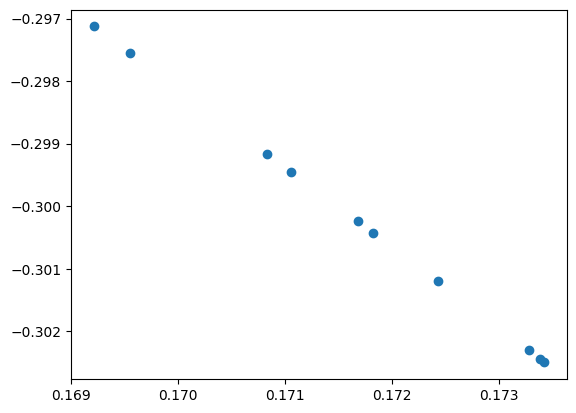

In [11]:
# Define a test timestep for adding noise to the data
test_noise_step = 5

# Add noise to a subset of the data (first 10 samples) at the specified timestep
data_noisy = get_noisy(data_transformed[:, 0:10], test_noise_step)

# Create a tensor representing the current timestep `test_noise_step` for each noisy data point
t_ = torch.Tensor([test_noise_step])  # Create a tensor with the value of the timestep
t_ = t_.repeat(10)  # Repeat the timestep value for all 10 samples

# Stack the noisy data and the timestep tensor vertically to create the input for the model
# The input now has shape (features + timestep, samples)
data_noisy = torch.vstack([data_noisy, t_])

# Disable gradient computation for testing
with torch.no_grad():
    # Perform multiple epochs of testing (though gradients and optimization are disabled)
    for epoch in range(1, epochs + 1):
        # Pass the noisy data through the model to predict the clean data
        data_pred = denoising_model(data_noisy.T)  # Transpose `data_noisy` to match input shape (samples, features)

        # Compute the loss between the model's predictions and the ground truth data
        loss_ = loss_func(data_transformed[:, 0:10].T, data_pred)

        # Note: The backward pass and optimizer step are commented out since this is a test loop
        # loss_.backward()
        # optimizer.step()

        # Log the loss value for this epoch
        loss, current = loss_.item(), 1 * 10  # `current` assumes a fixed batch size of 10
        print(f"loss: {loss:>7f}  [{current:>5d}/{batch_size:>5d}]")

# Output the predicted data and ground truth for inspection
print(data_pred, data_transformed[:, 1:10].T)

# Visualize the model's predictions using a scatter plot
# Plot the first two dimensions of the predicted data
plt.scatter(data_pred.T[0], data_pred.T[1])


In [12]:
# Import necessary libraries
import os
import os.path as osp
from copy import deepcopy
import pickle
import sys

# Set the number of epochs for training
epochs = 300

# Define the function to train the denoising model
def train_model(denoising_model, data_transformed, model_name):
    # Initialize the best loss to a very large value
    best_loss = sys.float_info.max

    # Define the path to save the best model's state
    ff = osp.join(os.getcwd(), 'saved_models', 'best', model_name + '_state.pkl')

    # List to store losses for each evaluation step
    losses = []

    # Loop over the specified number of epochs
    for epoch in range(1, epochs + 1):
        # Iterate over batches of data
        for n in range(1, int(len(data_transformed[0]) / batch_size) + 1):
            # Extract a batch of data for training
            data_in_batch = data_transformed[:, (n - 1) * batch_size : n * batch_size]

            # Randomly select timesteps for the batch
            idx = torch.randint(0, timesteps - 1, (batch_size,)).long()
            timestep = idx.add(1)  # Add 1 to shift timesteps to range [1, timesteps]

            # Add noise to the data batch at the selected timesteps
            data_noisy = get_noisy(data_in_batch, timestep)

            # Zero out the optimizer gradients
            optimizer.zero_grad(set_to_none=True)

            # Stack the noisy data and timestep as input to the model
            data_noisy_stacked = torch.vstack([data_noisy, timestep])

            # Pass the noisy data through the model to predict clean data
            pred_data = denoising_model(data_noisy_stacked.T)

            # Compute importance weights for the loss function
            imp_weight = torch.sqrt(
                1 / 2 * ((alphas_prev_[timestep] / (1 - alphas_prev_[timestep])) -
                         (alphas_[timestep] / (1 - alphas_[timestep])))
            )

            # Compute the loss between predicted data and ground truth, scaled by importance weights
            loss_ = loss_func(data_in_batch.mul(imp_weight), pred_data.T.mul(imp_weight))

            # Backpropagate the loss to compute gradients
            loss_.backward()

            # Update model parameters
            optimizer.step()

        # Evaluate the model on a fixed timestep to find the best model
        with torch.no_grad():
            # Use a fixed timestep (1) for evaluation
            one_timestep = torch.Tensor([1]).repeat(batch_size).long()
            data_noisy_temp = get_noisy(data_in_batch, one_timestep)
            data_noisy_stacked_temp = torch.vstack([data_noisy_temp, one_timestep])

            # Predict clean data from noisy data
            pred_data_temp = denoising_model(data_noisy_stacked_temp.T)

            # Compute the loss on the evaluation data
            loss_temp = loss_func(data_in_batch.mul(1), pred_data_temp.T.mul(1))
            losses.append(loss_temp.item())

        # Save the model if the current evaluation loss is better than the best loss so far
        if loss_temp.item() < best_loss:
            best_loss = loss_temp.item()
            print(f"saving epoch: {epoch} loss: {best_loss:>7f}")

        # Print loss every 20 epochs for monitoring
        if epoch % 20 == 0:
            loss = loss_temp.item()
            print(f"epoch: {epoch} loss: {loss:>7f}")

    # Return key values for further inspection or analysis
    return data_noisy, pred_data, data_in_batch, timestep, losses

# Train the denoising model and capture the outputs
data_noisy, pred_data, data_in_batch, timestep, losses = train_model(denoising_model, data_transformed, 'denoising_model')


saving epoch: 1 loss: 0.013753
saving epoch: 2 loss: 0.011963
saving epoch: 3 loss: 0.001828
saving epoch: 4 loss: 0.001030
saving epoch: 6 loss: 0.001001
saving epoch: 7 loss: 0.000812
saving epoch: 8 loss: 0.000635
saving epoch: 18 loss: 0.000579
saving epoch: 20 loss: 0.000556
epoch: 20 loss: 0.000556
saving epoch: 27 loss: 0.000538
saving epoch: 31 loss: 0.000537
saving epoch: 33 loss: 0.000534
saving epoch: 34 loss: 0.000517
epoch: 40 loss: 0.000539
saving epoch: 46 loss: 0.000513
saving epoch: 49 loss: 0.000471
epoch: 60 loss: 0.000487
epoch: 80 loss: 0.000520
saving epoch: 86 loss: 0.000456
saving epoch: 94 loss: 0.000435
epoch: 100 loss: 0.000499
epoch: 120 loss: 0.000476
epoch: 140 loss: 0.000435
epoch: 160 loss: 0.000499
epoch: 180 loss: 0.000524
epoch: 200 loss: 0.000544
saving epoch: 210 loss: 0.000427
epoch: 220 loss: 0.000530
epoch: 240 loss: 0.000464
epoch: 260 loss: 0.000705
epoch: 280 loss: 0.000682
saving epoch: 292 loss: 0.000423
epoch: 300 loss: 0.000446


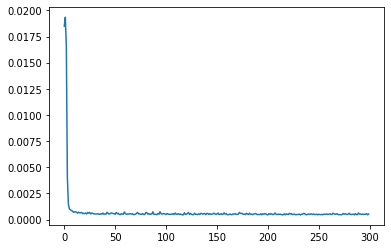

In [ ]:
plt.plot(torch.Tensor(losses))

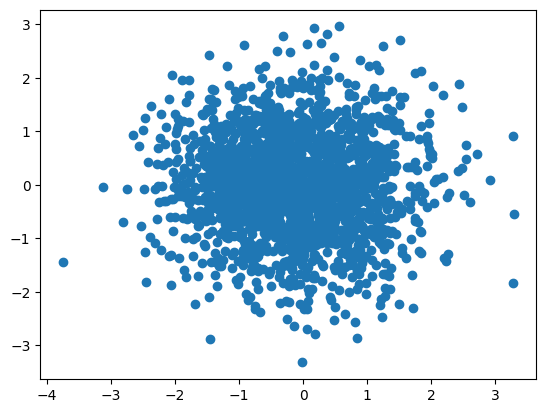

In [13]:
plt.scatter(data_noisy[0], data_noisy[1])

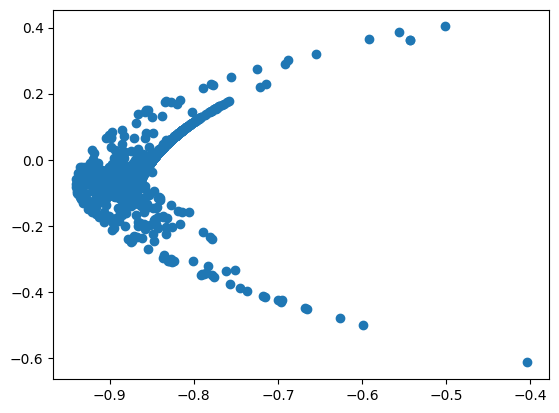

In [14]:
pd = pred_data.detach().numpy().T
plt.scatter(pd[0], pd[1])

In [15]:
data_in_batch[:10], pred_data[:10].T, timestep[:10]

(tensor([[-0.7395, -0.9002, -0.8198,  ..., -0.8703, -0.9262, -0.8945],
         [-0.3995, -0.1847, -0.2557,  ..., -0.2498, -0.1596, -0.1622]]),
 tensor([[-0.8690, -0.8990, -0.8248, -0.8689, -0.8422, -0.9032, -0.8731, -0.8364,
          -0.8269, -0.8781],
         [-0.0797, -0.1006,  0.0661, -0.1016,  0.0283, -0.0497, -0.0879, -0.1723,
           0.0615, -0.0884]], grad_fn=<PermuteBackward0>),
 tensor([ 82,  27, 156, 123,  36,  69,  49,  36, 180,  50]))

# generation of data

In [22]:
def generate_data(denoising_model):
    """
    Generate data using the trained denoising model via the reverse diffusion process.
    Args:
        denoising_model: The trained denoising model.
    Returns:
        datas: List of generated data at each timestep.
        data_in_batch: The final generated batch of data.
    """
    # Define the batch size for data generation
    batch_size_generation = 2048

    # Initialize noisy data for the reverse process (starting from standard Gaussian noise)
    data_noisy = torch.normal(mean=0, std=1, size=(2, batch_size_generation))  # Shape: (2, batch_size_generation)

    # List to store data at each timestep
    datas = []
    datas.append(data_noisy.cpu().detach())  # Save the initial noisy data

    # Iterate over batches of data
    for n in range(1, int(len(data_noisy[0]) / batch_size_generation) + 1):
        # Extract a batch of data
        data_in_batch = data_noisy[:, (n - 1) * batch_size_generation : n * batch_size_generation]

        # Reverse through timesteps to progressively denoise the data
        for t in range(1, timesteps):
            timestep = timesteps - t  # Start from the last timestep and move backward

            # Create a tensor of the current timestep repeated for the batch
            t_repeated = torch.Tensor([timestep]).repeat(batch_size_generation)

            # Stack the noisy data and timestep to create input for the model
            data_stacked = torch.vstack([data_in_batch, t_repeated])

            # Use the model to predict the clean data
            pred_data = denoising_model(data_stacked.T)

            # Compute the mean of the posterior distribution
            mean_data_1 = data_in_batch.T.mul(
                torch.sqrt(alphas[timestep]) * (1 - alphas_prev_[timestep]) / (variance[timestep])
            )
            mean_data_2 = pred_data.mul(
                torch.sqrt(alphas_prev_[timestep]) * (1 - alphas[timestep]) / (variance[timestep])
            )
            mean_data = mean_data_1.add(mean_data_2)

            # Compute the variance of the posterior distribution
            posterior_data = posterior_variance[timestep]

            # Sample the next batch of data using the computed mean and variance
            data_in_batch = torch.normal(mean_data, torch.sqrt(posterior_data)).T

            # Save the generated data for this timestep
            datas.append(data_in_batch.cpu().detach())

    # Return the list of generated data at each timestep and the final batch of data
    return datas, data_in_batch

# Generate data using the denoising model
datas, data_in_batch = generate_data(denoising_model)


(-20.0, 20.0)

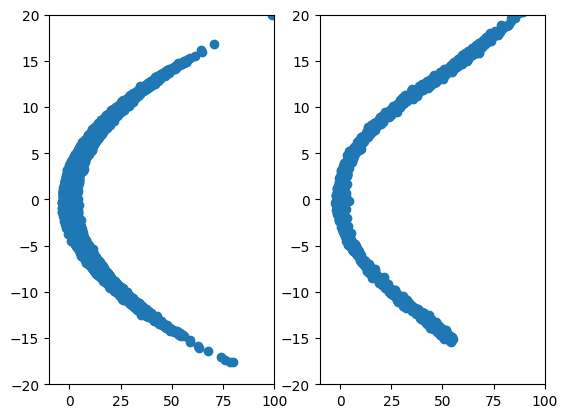

In [23]:
data_in_batch = data_in_batch.cpu().detach()
data_pred = reverse_transform(data_in_batch.cpu().detach(), min_, max_)
_, (ax1, ax2) = plt.subplots(1, 2)

ax1.scatter(data[0], data[1])
ax2.scatter(data_pred[0], data_pred[1])
ax1.set_xlim([-10, 100])
ax1.set_ylim([-20, 20])

ax2.set_xlim([-10, 100])
ax2.set_ylim([-20, 20])

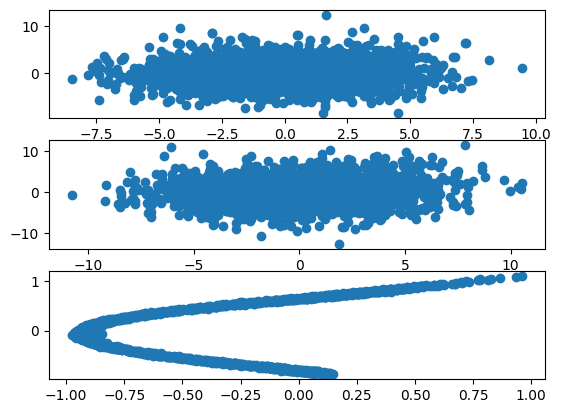

In [24]:
_, (ax5, ax6, ax7) = plt.subplots(3)

ax5.scatter(datas[timesteps - 100][0], datas[timesteps - 100][1])
ax6.scatter(datas[timesteps - 45][0], datas[timesteps - 45][1])
ax7.scatter(datas[timesteps - 1][0], datas[timesteps - 1][1])

# trying out different sklearn moon distributions

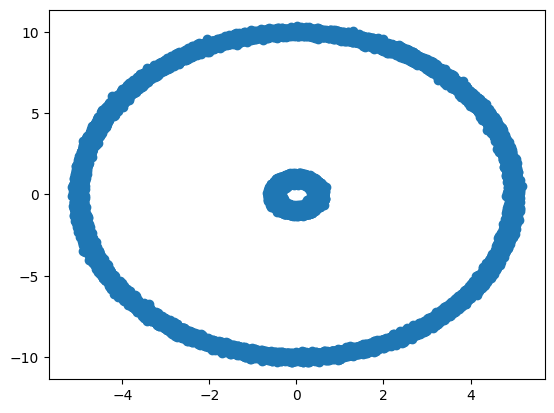

In [25]:
from sklearn import datasets
from matplotlib import pyplot as plt

circles, _ = datasets.make_circles(1024*128, noise=0.01, factor=0.1, shuffle=True)
circles = circles* [5., 10.]
circles = circles.T
plt.scatter(circles[0], circles[1])

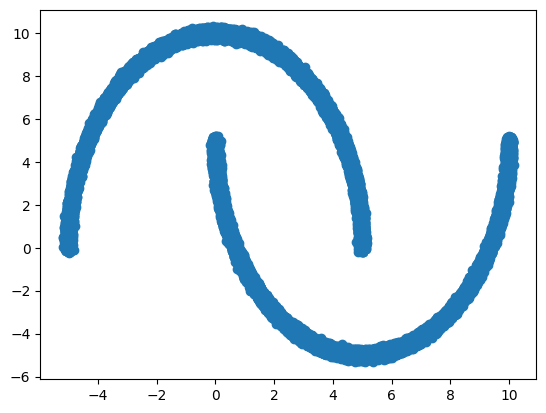

In [26]:
make_moons, labels = datasets.make_moons(n_samples=1024*128, noise=0.01)
make_moons = make_moons* [5., 10.]
make_moons = make_moons.T
plt.scatter(make_moons[0], make_moons[1])

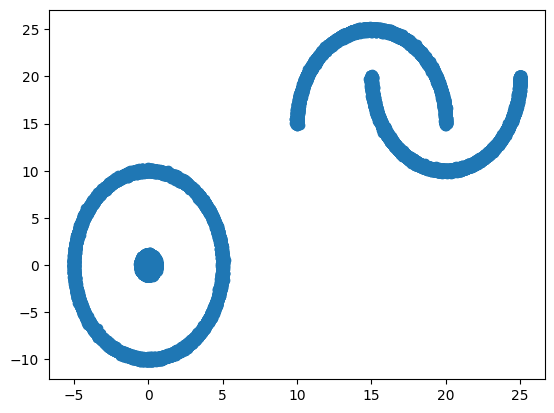

In [27]:
import numpy

complex_data = numpy.hstack([make_moons + 15, circles ])
numpy.random.shuffle(complex_data.T)

plt.scatter(complex_data[0], complex_data[1])

#### train models

DenoisingModel(
  (fc1): Linear(in_features=3, out_features=128, bias=True)
  (activation1): GELU(approximate='none')
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (activation2): GELU(approximate='none')
  (fc3): Linear(in_features=128, out_features=3, bias=True)
  (activation3): GELU(approximate='none')
  (fc4): Linear(in_features=3, out_features=128, bias=True)
  (activation4): GELU(approximate='none')
  (fc5): Linear(in_features=128, out_features=128, bias=True)
  (activation5): GELU(approximate='none')
  (fc6): Linear(in_features=128, out_features=3, bias=True)
  (activation6): GELU(approximate='none')
  (fc7): Linear(in_features=3, out_features=128, bias=True)
  (activation7): GELU(approximate='none')
  (fc8): Linear(in_features=128, out_features=128, bias=True)
  (activation8): GELU(approximate='none')
  (fc9): Linear(in_features=128, out_features=2, bias=True)
)
saving epoch: 1 loss: 0.063796
saving epoch: 2 loss: 0.014689
saving epoch: 3 loss: 0.002477
saving 

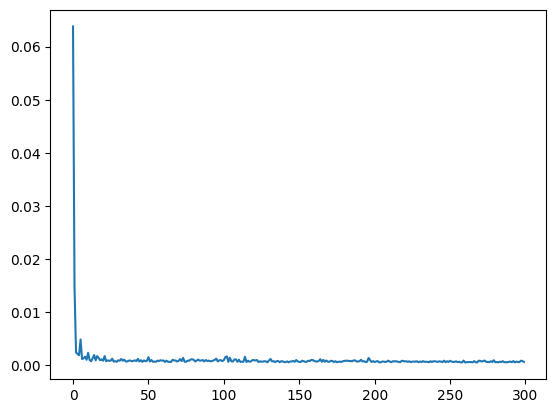

In [28]:
make_circles_model = DenoisingModel(128)
print(make_circles_model)

loss_func = nn.HuberLoss()
optimizer = torch.optim.Adam(make_circles_model.parameters(), lr=learning_rate)

circles = torch.Tensor(circles)
circles_normalized, min_circles, max_circles = transform(circles)
data_noisy, pred_data, data_in_batch, _, losses = train_model(make_circles_model, circles_normalized, 'make_circles_model')
plt.plot(torch.Tensor(losses))

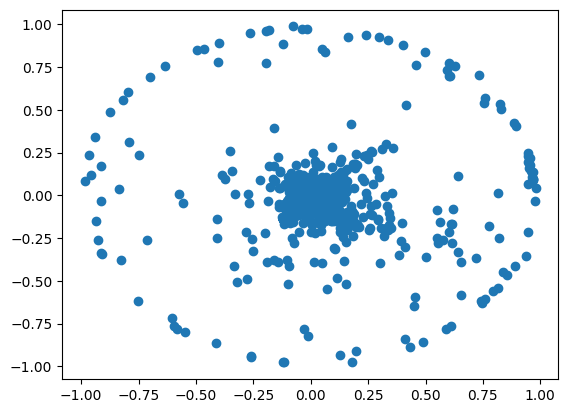

In [30]:
pd = pred_data.detach().numpy().T
plt.scatter(pd[0], pd[1])

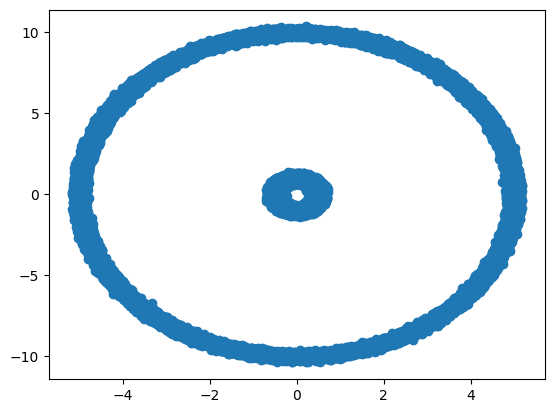

In [31]:
temp = get_noisy(circles, 1)
plt.scatter(temp[0], temp[1])

In [32]:
datas, data_in_batch = generate_data(make_circles_model)

(-10.0, 10.0)

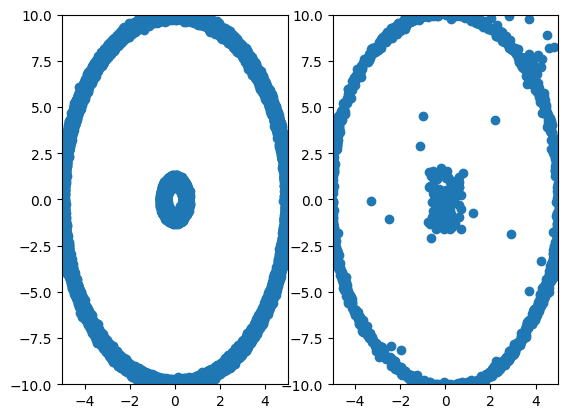

In [33]:
data_in_batch = data_in_batch.cpu().detach()
data_pred = reverse_transform(data_in_batch.cpu().detach(), min_circles, max_circles)
_, (ax1, ax2) = plt.subplots(1, 2)

ax1.scatter(circles[0], circles[1])
ax2.scatter(data_pred[0], data_pred[1])
ax1.set_xlim([-5, 5])
ax1.set_ylim([-10, 10])

ax2.set_xlim([-5, 5])
ax2.set_ylim([-10, 10])

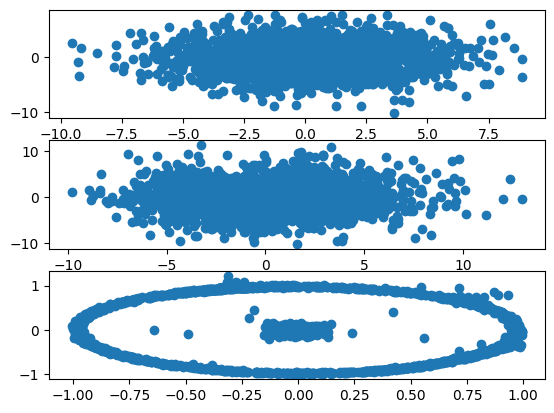

In [34]:
_, (ax5, ax6, ax7) = plt.subplots(3)

ax5.scatter(datas[timesteps - 100][0], datas[timesteps - 100][1])
ax6.scatter(datas[timesteps - 45][0], datas[timesteps - 45][1])
ax7.scatter(datas[timesteps - 1][0], datas[timesteps - 1][1])

#### make moons

DenoisingModel(
  (fc1): Linear(in_features=3, out_features=128, bias=True)
  (activation1): GELU(approximate='none')
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (activation2): GELU(approximate='none')
  (fc3): Linear(in_features=128, out_features=3, bias=True)
  (activation3): GELU(approximate='none')
  (fc4): Linear(in_features=3, out_features=128, bias=True)
  (activation4): GELU(approximate='none')
  (fc5): Linear(in_features=128, out_features=128, bias=True)
  (activation5): GELU(approximate='none')
  (fc6): Linear(in_features=128, out_features=3, bias=True)
  (activation6): GELU(approximate='none')
  (fc7): Linear(in_features=3, out_features=128, bias=True)
  (activation7): GELU(approximate='none')
  (fc8): Linear(in_features=128, out_features=128, bias=True)
  (activation8): GELU(approximate='none')
  (fc9): Linear(in_features=128, out_features=2, bias=True)
)
saving epoch: 1 loss: 0.054825
saving epoch: 2 loss: 0.001645
saving epoch: 4 loss: 0.001615
saving 

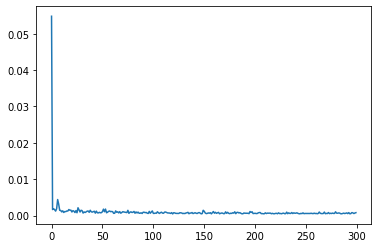

In [ ]:
make_moons_model = DenoisingModel(128)
print(make_moons_model)

loss_func = nn.HuberLoss()
optimizer = torch.optim.Adam(make_moons_model.parameters(), lr=learning_rate)

make_moons = torch.Tensor(make_moons)
make_moons_normalized, min_moons, max_moons = transform(make_moons)
data_noisy, pred_data, data_in_batch, _, losses = train_model(make_moons_model, make_moons_normalized, 'make_moons_model')
plt.plot(torch.Tensor(losses))

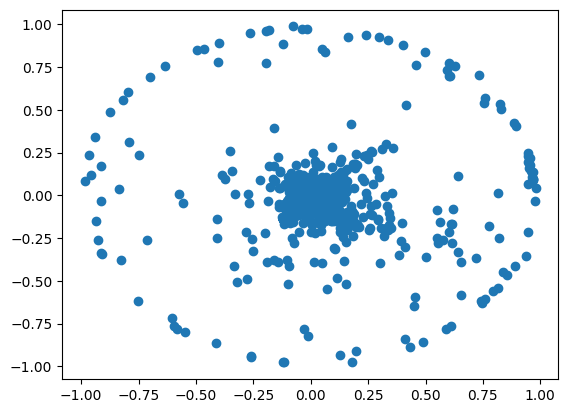

In [29]:
pd = pred_data.detach().numpy().T
plt.scatter(pd[0], pd[1])

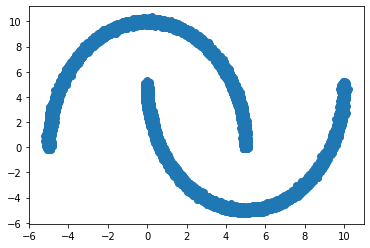

In [ ]:
temp = get_noisy(make_moons, 1)
plt.scatter(temp[0], temp[1])

In [ ]:
datas, data_in_batch = generate_data(make_moons_model)

(-10.0, 10.0)

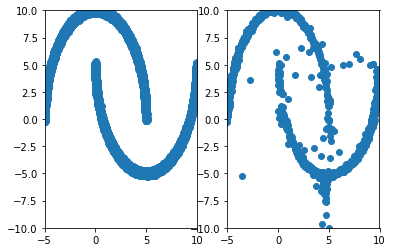

In [ ]:
data_in_batch = data_in_batch.cpu().detach()
data_pred = reverse_transform(data_in_batch.cpu().detach(), min_moons, max_moons)
_, (ax1, ax2) = plt.subplots(1, 2)

ax1.scatter(make_moons[0], make_moons[1])
ax2.scatter(data_pred[0], data_pred[1])
ax1.set_xlim([-5, 10])
ax1.set_ylim([-10, 10])

ax2.set_xlim([-5, 10])
ax2.set_ylim([-10, 10])

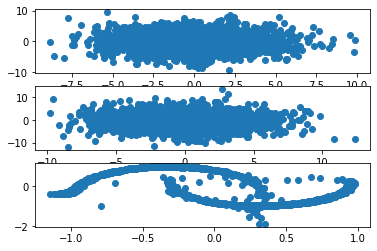

In [ ]:
_, (ax5, ax6, ax7) = plt.subplots(3)

ax5.scatter(datas[timesteps - 100][0], datas[timesteps - 100][1])
ax6.scatter(datas[timesteps - 45][0], datas[timesteps - 45][1])
ax7.scatter(datas[timesteps - 1][0], datas[timesteps - 1][1])

#### complex data distribution

DenoisingModel(
  (fc1): Linear(in_features=3, out_features=128, bias=True)
  (activation1): GELU(approximate='none')
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (activation2): GELU(approximate='none')
  (fc3): Linear(in_features=128, out_features=3, bias=True)
  (activation3): GELU(approximate='none')
  (fc4): Linear(in_features=3, out_features=128, bias=True)
  (activation4): GELU(approximate='none')
  (fc5): Linear(in_features=128, out_features=128, bias=True)
  (activation5): GELU(approximate='none')
  (fc6): Linear(in_features=128, out_features=3, bias=True)
  (activation6): GELU(approximate='none')
  (fc7): Linear(in_features=3, out_features=128, bias=True)
  (activation7): GELU(approximate='none')
  (fc8): Linear(in_features=128, out_features=128, bias=True)
  (activation8): GELU(approximate='none')
  (fc9): Linear(in_features=128, out_features=2, bias=True)
)
saving epoch: 1 loss: 0.022270
saving epoch: 2 loss: 0.018704
saving epoch: 3 loss: 0.013612
saving 

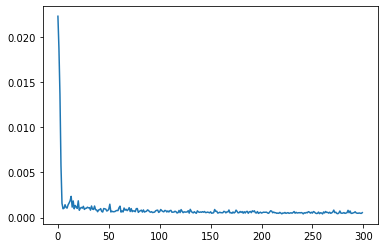

In [ ]:
make_complex_model = DenoisingModel(128)
print(make_complex_model)

loss_func = nn.HuberLoss()
optimizer = torch.optim.Adam(make_complex_model.parameters(), lr=learning_rate)

complex_data = torch.Tensor(complex_data)
complex_data_normalized, min_complex, max_complex = transform(complex_data)
data_noisy, pred_data, data_in_batch, _, losses = train_model(make_complex_model, complex_data_normalized, 'make_complex_model')
plt.plot(torch.Tensor(losses))

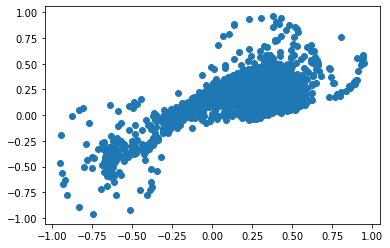

In [ ]:
pd = pred_data.detach().numpy().T
plt.scatter(pd[0], pd[1])

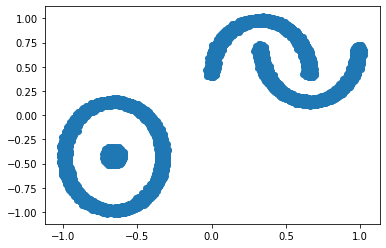

In [ ]:
# complex_data = torch.Tensor(complex_data)
# complex_data_normalized, min_complex, max_complex = transform(complex_data)

temp = get_noisy(complex_data_normalized, 0)
plt.scatter(temp[0], temp[1])

In [ ]:
datas, data_in_batch = generate_data(make_complex_model)

(-10.0, 30.0)

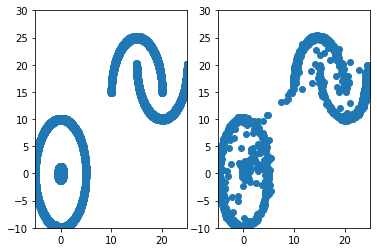

In [ ]:
data_in_batch = data_in_batch.cpu().detach()
data_pred = reverse_transform(data_in_batch.cpu().detach(), min_complex, max_complex)
_, (ax1, ax2) = plt.subplots(1, 2)

ax1.scatter(complex_data[0], complex_data[1])
ax2.scatter(data_pred[0], data_pred[1])
ax1.set_xlim([-5, 25])
ax1.set_ylim([-10, 30])

ax2.set_xlim([-5, 25])
ax2.set_ylim([-10, 30])

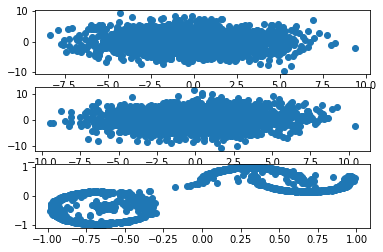

In [ ]:
_, (ax5, ax6, ax7) = plt.subplots(3)

ax5.scatter(datas[timesteps - 100][0], datas[timesteps - 100][1])
ax6.scatter(datas[timesteps - 45][0], datas[timesteps - 45][1])
ax7.scatter(datas[timesteps - 1][0], datas[timesteps - 1][1])